In [57]:
import importlib
from pathlib import Path

import numpy as np
import pandas as pd

import config
import module
from tests import test

for p in [config, module,test]:
    try:
        importlib.reload(p)  # reload module
    except NameError:
        pass

In [58]:
# load DFs
df_att = pd.read_excel(config.path_attendance_data)
df_sess = pd.read_excel(config.path_session_data)
df_trainer = pd.read_excel(config.path_trainer_data, sheet_name=config.month)
df_noncoco = pd.read_excel(
    config.path_noncoco, 
    sheet_name=config.month_noncoco, 
    engine="openpyxl"
)
df_coco_member = pd.read_excel(config.path_coco_member)
df_erwin_member = pd.read_parquet(config.path_erwin_member)

# Clean and Merge DF

## DF Session

In [59]:
# add data source column to df_sess
# drop index column
# sort column alphabetically
df_sess= (df_sess
    .assign(data_source= 'coco')
    .drop(columns= 'index')
    .loc[:, lambda df_: sorted(df_.columns)]
)

## DF Noncoco

In [60]:
# map center to area
list_center = df_sess.groupby(["class_area", "class_location"]).size().index.to_list()
map_center = {center: area for (area, center) in list_center}

# map class service
map_service = {
    "Deluxe": "Deluxe",
    "Deluxe + Go": "Deluxe & Go",
    "Deluxe & Go": "Deluxe & Go",
    "VIP": "VIP",
    "IELTS": "Other",
    "Proskill": "Other",
    "Club": "Other",
    "Other": "Other",
    "Prospect": "Other",
    "GO": "Go",
    "Go": "Go",
    np.nan: "Other",
}


# clean df noncoco
df_noncoco_cleaned = (
    df_noncoco
    # get only necessary columns
    .loc[
        :,
        [
            "Teacher",
            "Class Date",
            "Class Time",
            "Class Type",
            "Class Location",
            "Class Service",
            "Class Attendance",
            "Class Booking",
            "Class Description",
            "Class Duration",
            "Class Status",
        ],
    ].rename(columns=lambda c: c.lower().replace(" ", "_"))
    # if the teacher is na, drop the rows
    .dropna(subset="teacher")
    # note: clean columns
    .assign(
        class_type=lambda df_: (
            df_["class_type"]
            .str.strip()
            .fillna("Other")
            .replace("Deluxe + Go", "Deluxe & Go")
        ),
        class_date=lambda df_: pd.to_datetime(df_["class_date"]),
        # get first 4 digits of the time
        class_time=lambda df_: df_["class_time"].astype(str).str[:5],
        teacher=lambda df_: df_["teacher"].astype(str).str.strip(),
        # map class service
        class_service=lambda df_: df_["class_service"].map(map_service),
        # if class_status == na, fill with given
        class_status=lambda df_: df_["class_status"].fillna("Given"),
        class_description=lambda df_: df_["class_description"].str.lower(),
        # fill missing class duration with 1
        class_duration=lambda df_: df_["class_duration"].fillna(1),
        # cast class attendance into float
        class_attendance=lambda df_: pd.to_numeric(
            df_["class_attendance"], errors="coerce"
        ),
    )
    # note: create new columns
    .assign(
        data_source="noncoco",
        class_mode=lambda df_: np.where(
            df_["class_type"].str.lower().str.contains("online"), "Online", "Offline"
        ),
        class_type_grouped=lambda df_: module.create_class_type_noncoco(
            df_, "class_type", "class_mode", "class_service"
        ),
    )
    # if online, make class location online
    # map the class location
    .assign(
        class_location=lambda df_: module.clean_online_class_location(df_),
        class_area=lambda df_: df_["class_location"].map(map_center).fillna("Other"),
    )
    # drop rows where class date is not current month
    .loc[lambda df_: df_["class_date"].dt.month == config.month_number]
    # merge with df trainer to get teacher center and area
    .merge(df_trainer, how="left", on="teacher")
    # drop unused columns
    .drop(columns=["teacher_note_1", "teacher_note_2", "teacher_working_days"])
    # sort column alphabetically
    .loc[:, lambda df_: sorted(df_.columns)]
    # drop null cols
    .dropna(how="all", axis=0)
    # .dropna(how= 'all', axis= 1)
    .loc[:, lambda df_: ~df_.columns.str.contains("Unnamed")]
)
df_noncoco_cleaned.head(3)

,class_area,class_attendance,class_booking,class_date,class_description,class_duration,class_location,class_mode,class_service,class_status,class_time,class_type,class_type_grouped,data_source,teacher,teacher_area,teacher_center,teacher_position
0,JKT 2,NaN,NaN,2023-12-01,fl deluxe,2.0,GC,Offline,Deluxe,Given,19:00,FL,First Lesson,noncoco,Hazisyah Alifia Nur,JKT 2,GC,Coach
1,JKT 3,NaN,NaN,2023-12-01,fl deluxe,2.0,KK,Offline,Deluxe,Given,19:00,FL,First Lesson,noncoco,Prasheena Kainaz,JKT 3,KK,Coach
2,Online,NaN,NaN,2023-12-01,fl go,2.0,Online,Online,Go,Given,14:00,Online FL,Online First Lesson,noncoco,Saputri Okfitasari Hana,JKT 3,CBB,Coach


## Merge DF

In [61]:
# merge df session and df noncoco
df_sess_full = pd.concat([df_sess, df_noncoco_cleaned], axis=0)
df_sess_full = (
    df_sess_full.reset_index(drop=True)
    .assign(index=lambda df_: df_.index + 1)
    .assign(
        class_duration=lambda df_: pd.to_numeric(df_["class_duration"], errors="raise"),
        class_grouping=lambda df_: df_["class_type_grouped"].map(module.class_grouping),
    )
)
df_sess_full.shape

(5310, 20)

## Test

In [62]:
test.test_noncoco_online_class_is_online_location(df_noncoco_cleaned)
test.test_coco_and_noncoco_cols_same(df_sess, df_noncoco_cleaned)
test.test_class_exist_in_module_class_grouping(df_sess_full)
test.test_teacher_center_area_position_not_null(df_sess_full)
test.test_no_trainer_is_duplicated(df_trainer)

# Sheet 3: Class Session & util

In [63]:
class_session = (
    df_sess_full
    # ! exclude GOC
    .loc[df_sess_full["class_mode"] != "GOC"]
    .groupby(["class_grouping", "class_mode", "class_type_grouped"])
    .agg(
        total_scheduled_session=("index", "nunique"),
        # count how many rows have status "Given"
        total_delivered_session=("class_status", lambda c: (c == "Given").sum()),
        # use sum first because to obtain avg, have to divide sum by num of classes
        total_attendance=("class_attendance", "sum"),
    )
    # assign max attendance per class type
    .assign(
        max_attendance=lambda df_: df_.index.get_level_values(2).map(
            module.class_target
        )
    )
    .astype("Int64")
    .assign(
        avg_attendance=lambda df_: df_["total_attendance"]
        .div(df_["total_delivered_session"])
        .round(1),
        avg_per_max_attendance=lambda df_: df_["avg_attendance"]
        .div(df_["max_attendance"])
        .round(2),
    )
    # sort index top place "Other" below
    .sort_index(level=0, ascending=False)
    .assign(
        percentage_delivered=lambda df_: df_["total_delivered_session"]
        .div(df_["total_scheduled_session"])
        .astype(float)
        .round(2),
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["", "Class Mode", "Class Type Grouped"])
    .loc[
        :,
        [
            "Total Scheduled Session",
            "Total Delivered Session",
            "Percentage Delivered",
            "Max Attendance",
            "Avg Attendance",
            "Avg Per Max Attendance",
        ],
    ]
)

class_session

Total Scheduled Session  \
         Class Mode Class Type Grouped                                      
VIP      Online     Online VPG                                        127   
                    Online One-on-one                                 384   
         Offline    VPG                                                58   
                    One-on-one                                        420   
Standard Online     Online Social Club                                218   
                    Online First Lesson                                78   
                    Online Complementary                              361   
                    Online Community                                   34   
                    Online Advising Session                             3   
         Offline    Social Club                                       364   
                    Member's Party                                      9   
                    First Lesson                                       98   
                    Complementary                                     380   
                    Community                                          76   
                    Chat Hour                                         233   
                    Advising Session                                   46   
Other    Online     Online Proskill First Lesson                        2   
                    Online Proskill                                     7   
                    Online Other                                       33   
                    Online IELTS First Lesson                          10   
                    Online IELTS                                        6   
         Offline    Proskill First Lesson                               3   
                    Proskill                                           12   
                    Other                                             437   
                    Mock Test                                          14   
                    IELTS First Lesson                                  2   
                    IELTS                                              26   

                                                  Total Delivered Session  \
         Class Mode Class Type Grouped                                      
VIP      Online     Online VPG                                         88   
                    Online One-on-one                                 217   
         Offline    VPG                                                55   
                    One-on-one                                        293   
Standard Online     Online Social Club                                216   
                    Online First Lesson                                75   
                    Online Complementary                              357   
                    Online Community                                   33   
                    Online Advising Session                             2   
         Offline    Social Club                                       329   
                    Member's Party                                      9   
                    First Lesson                                       94   
                    Complementary                                     324   
                    Community                                          71   
                    Chat Hour                                         230   
                    Advising Session                                   42   
Other    Online     Online Proskill First Lesson                        2   
                    Online Proskill                                     7   
                    Online Other                                       28   
                    Online IELTS First Lesson                          10   
                    Online IELTS                                        6   
         Offline    Proskill First Lesson    

# Sheet 4: ET Utilization

In [64]:
et_excluded= []

et_util = (
    df_sess_full
    # merge with df trainer to get working days etc
    .merge(df_trainer, how="left", on="teacher")
    # ! exclude et if less than 1 month
    .loc[lambda df_: ~(df_['teacher'].isin(et_excluded))]
    # to calculate class duration for delivered only,
    # create a temp column
    # if given, leave, if not given, 0
    .assign(
        class_duration_delivered=lambda df_: np.where(
            df_["class_status"] == "Given", df_["class_duration"], 0
        )
    )
    .groupby(["teacher_position_y", "teacher_area_x", "teacher"])
    .agg(
        working_days=("teacher_working_days", "mean"),
        total_scheduled_hours=("class_duration", "sum"),
        total_delivered_hours=("class_duration_delivered", "sum"),
    )
    # filter only for ET and coach
    .loc[
        lambda df_: df_.index.get_level_values("teacher_position_y").isin(
            ["ET", "Coach"]
        )
    ]
    .assign(
        working_days=lambda df_: df_["working_days"].astype("Int64"),
        total_scheduled_hours=lambda df_: df_["total_scheduled_hours"].astype(int),
        total_delivered_hours=lambda df_: df_["total_delivered_hours"].astype(int),
        scheduled_hours_per_day=lambda df_: (
            df_["total_scheduled_hours"].div(df_["working_days"]).round(1)
        ),
        delivered_hours_per_day=lambda df_: (
            df_["total_delivered_hours"].div(df_["working_days"]).round(1)
        ),
        max_class_hours=lambda df_: module.create_max_hour_per_trainer(df_),
        scheduled_utilization=lambda df_: df_["scheduled_hours_per_day"]
        .div(df_["max_class_hours"])
        .round(2),
        delivered_utilization=lambda df_: df_["delivered_hours_per_day"]
        .div(df_["max_class_hours"])
        .round(2),
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["Teacher Position", "Teacher Area", "Teacher"])
)
print(et_util.shape)
et_util.head()

(33, 8)


Working Days  \
Teacher Position Teacher Area Teacher                                    
Coach            BDG          Mustikawati Eka                       20   
                 JKT 1        Hamsah Handayani Ratnasari            21   
                              Mordechai Kaleb Arthur                20   
                              Oktavia Cindy                         21   
                              Rifani Aurora Nurhidayah              21   

                                                          Total Scheduled Hours  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                               120   
                 JKT 1        Hamsah Handayani Ratnasari                    125   
                              Mordechai Kaleb Arthur                        111   
                              Oktavia Cindy                                 103   
                              Rifani Aurora Nurhidayah                      113   

                                                          Total Delivered Hours  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                               103   
                 JKT 1        Hamsah Handayani Ratnasari                    112   
                              Mordechai Kaleb Arthur                         89   
                              Oktavia Cindy                                  69   
                              Rifani Aurora Nurhidayah                       88   

                                                          Scheduled Hours Per Day  \
Teacher Position Teacher Area Teacher                                               
Coach            BDG          Mustikawati Eka                                 6.0   
                 JKT 1        Hamsah Handayani Ratnasari                      6.0   
                              Mordechai Kaleb Arthur                          5.6   
                              Oktavia Cindy                                   4.9   
                              Rifani Aurora Nurhidayah                        5.4   

                                                          Delivered Hours Per Day  \
Teacher Position Teacher Area Teacher                                               
Coach            BDG          Mustikawati Eka                                 5.2   
                 JKT 1        Hamsah Handayani Ratnasari                      5.3   
                              Mordechai Kaleb Arthur                          4.4   
                              Oktavia Cindy                                   3.3   
                              Rifani Aurora Nurhidayah                        4.2   

                                                          Max Class Hours  \
Teacher Position Teacher Area Teacher                                       
Coach            BDG          Mustikawati Eka                         5.0   
                 JKT 1        Hamsah Handayani Ratnasari              5.0   
                              Mordechai Kaleb Arthur                  5.0   
                              Oktavia Cindy                           5.0   
                              Rifani Aurora Nurhidayah                5.0   

                                                          Scheduled Utilization  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                               1.2   
                 JKT 1        Hamsah Handayani Ratnasari                    1.2   
                              Mordechai Kaleb Arthur                       1.12   
                              Oktavia Cindy                                0.98   
                              Rifani Aurora Nurhidayah                     1.08   

                                                          Del

# Sheet 5: Ooolab

In [65]:
ooolab= (df_sess_full
    .loc[df_sess_full['teacher_center'] == 'Ooolab']
    .groupby(['class_service', 'class_mode', 'class_type_grouped', 'class_type'])
    .size()
    .to_frame()
    .rename(columns= {0: 'count'})
    .rename(columns= lambda c: c.replace('_', ' ').title())
    .rename_axis(['Class Service', 'Class Mode', 'Class Type Grouped', 'Class Type'])
)
ooolab

Count
Class Service Class Mode Class Type Grouped   Class Type                  
Deluxe & Go   Online     Online Complementary Online Complementary     113
                         Online Social Club   Online Social Club        66
VIP           Online     Online VPG           Online Complementary       4
                                              Online English Corner     67

# Sheet 6: Community

In [66]:
df_comm = (
    df_sess
    # filter for community
    .loc[df_sess["class_type_grouped"].isin(["Online Community", "Community"])]
    .assign(
        # create com name
        community_name=lambda df_: module.create_com_class(df_["class_description"]),
        # create com class type
        community_class_type=lambda df_: module.create_com_class_type(
            df_["class_description"]
        ),
    )
    .groupby(["community_name", "community_class_type", "class_mode"])
    .agg(
        # get avg attendance
        avg_attendance=("class_attendance", lambda x: x.mean().round(1))
    )
    .reset_index()
    .pivot(columns="community_name", index=["community_class_type", "class_mode"])
    .transpose()
    .rename_axis(["", ""], axis=1)
    .rename_axis(["", ""], axis=1)
    .reset_index()
    .drop(columns="level_0", level=0)
    .rename(columns={"community_name": "Community"})
)
df_comm

Community Meet Up        Showcase        Workshop       
             Offline Online  Offline Online  Offline Online
0      CRE-8     6.0   13.8      NaN   13.0      4.9   11.0
1       Leap     7.9   14.0      NaN   22.0      6.3   23.3
2  Re-Charge     7.0   19.8      NaN   31.0      5.3    8.3
3  Syndicate     7.8   16.8     18.0    NaN      6.4   17.2

In [67]:
df_comm_full = (
    df_sess
    # filter for community
    .loc[df_sess["class_type_grouped"].isin(["Online Community", "Community"])]
    .assign(
        # create com name
        community_name=lambda df_: module.create_com_class(
            df_["class_description"]
        ),
        # create com class type
        community_class_type=lambda df_: module.create_com_class_type(
            df_["class_description"]
        ),
    )
    .groupby(["community_name", "community_class_type", "class_mode"])
    .agg(
        total_scheduled_session=("community_class_type", "count"),
        total_delivered_session=("class_status", lambda i: (i == "Given").sum()),
        total_attendance=("class_attendance", "sum"),
        avg_attendance=("class_attendance", "mean"),
    )
    .assign(
        avg_attendance=lambda df_: df_["avg_attendance"].round(1),
        percentage_delivered=lambda df_: df_["total_delivered_session"]
        .div(df_["total_scheduled_session"])
        .round(2),
    )[
        [
            "total_scheduled_session",
            "total_delivered_session",
            "percentage_delivered",
            "total_attendance",
            "avg_attendance",
        ]
    ]
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["Community", "Class Type", "Class Mode"])
)
df_comm_full.head()

Total Scheduled Session  \
Community Class Type Class Mode                            
CRE-8     Meet Up    Offline                           9   
                     Online                            4   
          Showcase   Online                            1   
          Workshop   Offline                           9   
                     Online                            4   

                                 Total Delivered Session  \
Community Class Type Class Mode                            
CRE-8     Meet Up    Offline                           9   
                     Online                            4   
          Showcase   Online                            1   
          Workshop   Offline                           8   
                     Online                            4   

                                 Percentage Delivered  Total Attendance  \
Community Class Type Class Mode                                           
CRE-8     Meet Up    Offline                     1.00                54   
                     Online                      1.00                55   
          Showcase   Online                      1.00                13   
          Workshop   Offline                     0.89                44   
                     Online                      1.00                44   

                                 Avg Attendance  
Community Class Type Class Mode                  
CRE-8     Meet Up    Offline                6.0  
                     Online                13.8  
          Showcase   Online                13.0  
          Workshop   Offline                4.9  
                     Online                11.0

# Sheet 7: Member Cohort

## Load DFs

In [68]:
# create a date range from jan 2023 to current month
date_ranges = pd.date_range(
    start="2023-01-01",
    end=(pd.to_datetime(config.month, format="%m %b %Y") + pd.offsets.MonthEnd(0)),
    freq="m",
    inclusive="both",
)

# create a date range from jan 2023 to current month in a readable format
month_ranges = [i.strftime("%m %b %Y").lower() for i in date_ranges]

# list of all att files
att_files = [
    f"{config.path_attendance_data_parent}/{i}/data attendance {i[3:]}.xlsx"
    for i in month_ranges
]

# get all att files and concat
dfs = []
for file in att_files:
    try:
        df = pd.read_excel(
            file, usecols=["student_code", "class_date", "student_attendance"]
        )
        dfs.append(df)
    except FileNotFoundError:
        pass
df_att_all_mo = pd.concat(dfs, ignore_index=True)
print(len(date_ranges), len(dfs))

## Create Cohort

In [ ]:
cohort_start_date = (
    pd.to_datetime(config.month, format="%m %b %Y") 
    - pd.Timedelta(days=330)
    - pd.offsets.MonthBegin(1) # make this the beginning of the month
)
cohort_end_date = (
    pd.to_datetime(config.month, format="%m %b %Y") 
    + pd.offsets.MonthEnd(0)  # make this the end of the month
)
print(
    f"cohort start :{cohort_start_date: '%d %b %Y'}, cohort end :{cohort_end_date: '%d %b %Y'}"
)

cohort start : '01 Jan 2023', cohort end : '31 Dec 2023'


In [ ]:
# the date on which the member join
df_member_clean = (
    df_coco_member.rename(columns={"start_date": "date"}).assign(is_first=True)
    # loc date between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_date)
        & (df_["date"] <= cohort_end_date),
        ["student_code", "date", "is_first"],
    ]
)

# attendance of all member
df_att_all_mo_clean = (
    df_att_all_mo.loc[lambda df_: df_["student_attendance"] == "Attend"]  # only attend
    .drop(columns=["student_attendance"])
    .rename(columns={"class_date": "date"})
    # loc attendance between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_date)
        & (df_["date"] <= cohort_end_date)
    ]
    # only include members who are in df_member_clean
    # else, old members who started before that will be in the data
    .loc[lambda df_: df_["student_code"].isin(
        df_member_clean["student_code"].unique()
    )]
)

# concat att and member
df_cohort_raw = (
    pd.concat([df_member_clean, df_att_all_mo_clean])
    # drop the same date
    .sort_values(["is_first", "date"])
    .drop_duplicates(subset=["student_code", "date"], keep="first")
    .drop(columns=["is_first"])
    .assign(date=lambda df_: pd.to_datetime(df_["date"]))
    .rename(columns={
        "student_code": "customer_id", 
        "date": "transaction_date"
    })
)

# note: somehow, there are members who started lesson before contract start
# for now, no time to check
# last time checked, there are 125 members
# which is about 3 percent (negligible)
def get_members_study_before_contract_start():
    return (df_cohort_raw
        .fillna(False)
        .assign(is_first=lambda df_: df_["is_first"].astype(str))
        .groupby(["customer_id", "is_first"])
        ["transaction_date"].min()
        .to_frame()
        .reset_index()
        .pivot(index="customer_id", columns="is_first")
        .reset_index()
        .droplevel(0, axis="columns")
        .loc[
            lambda df_: df_["True"] > df_["False"]
        ]
    )

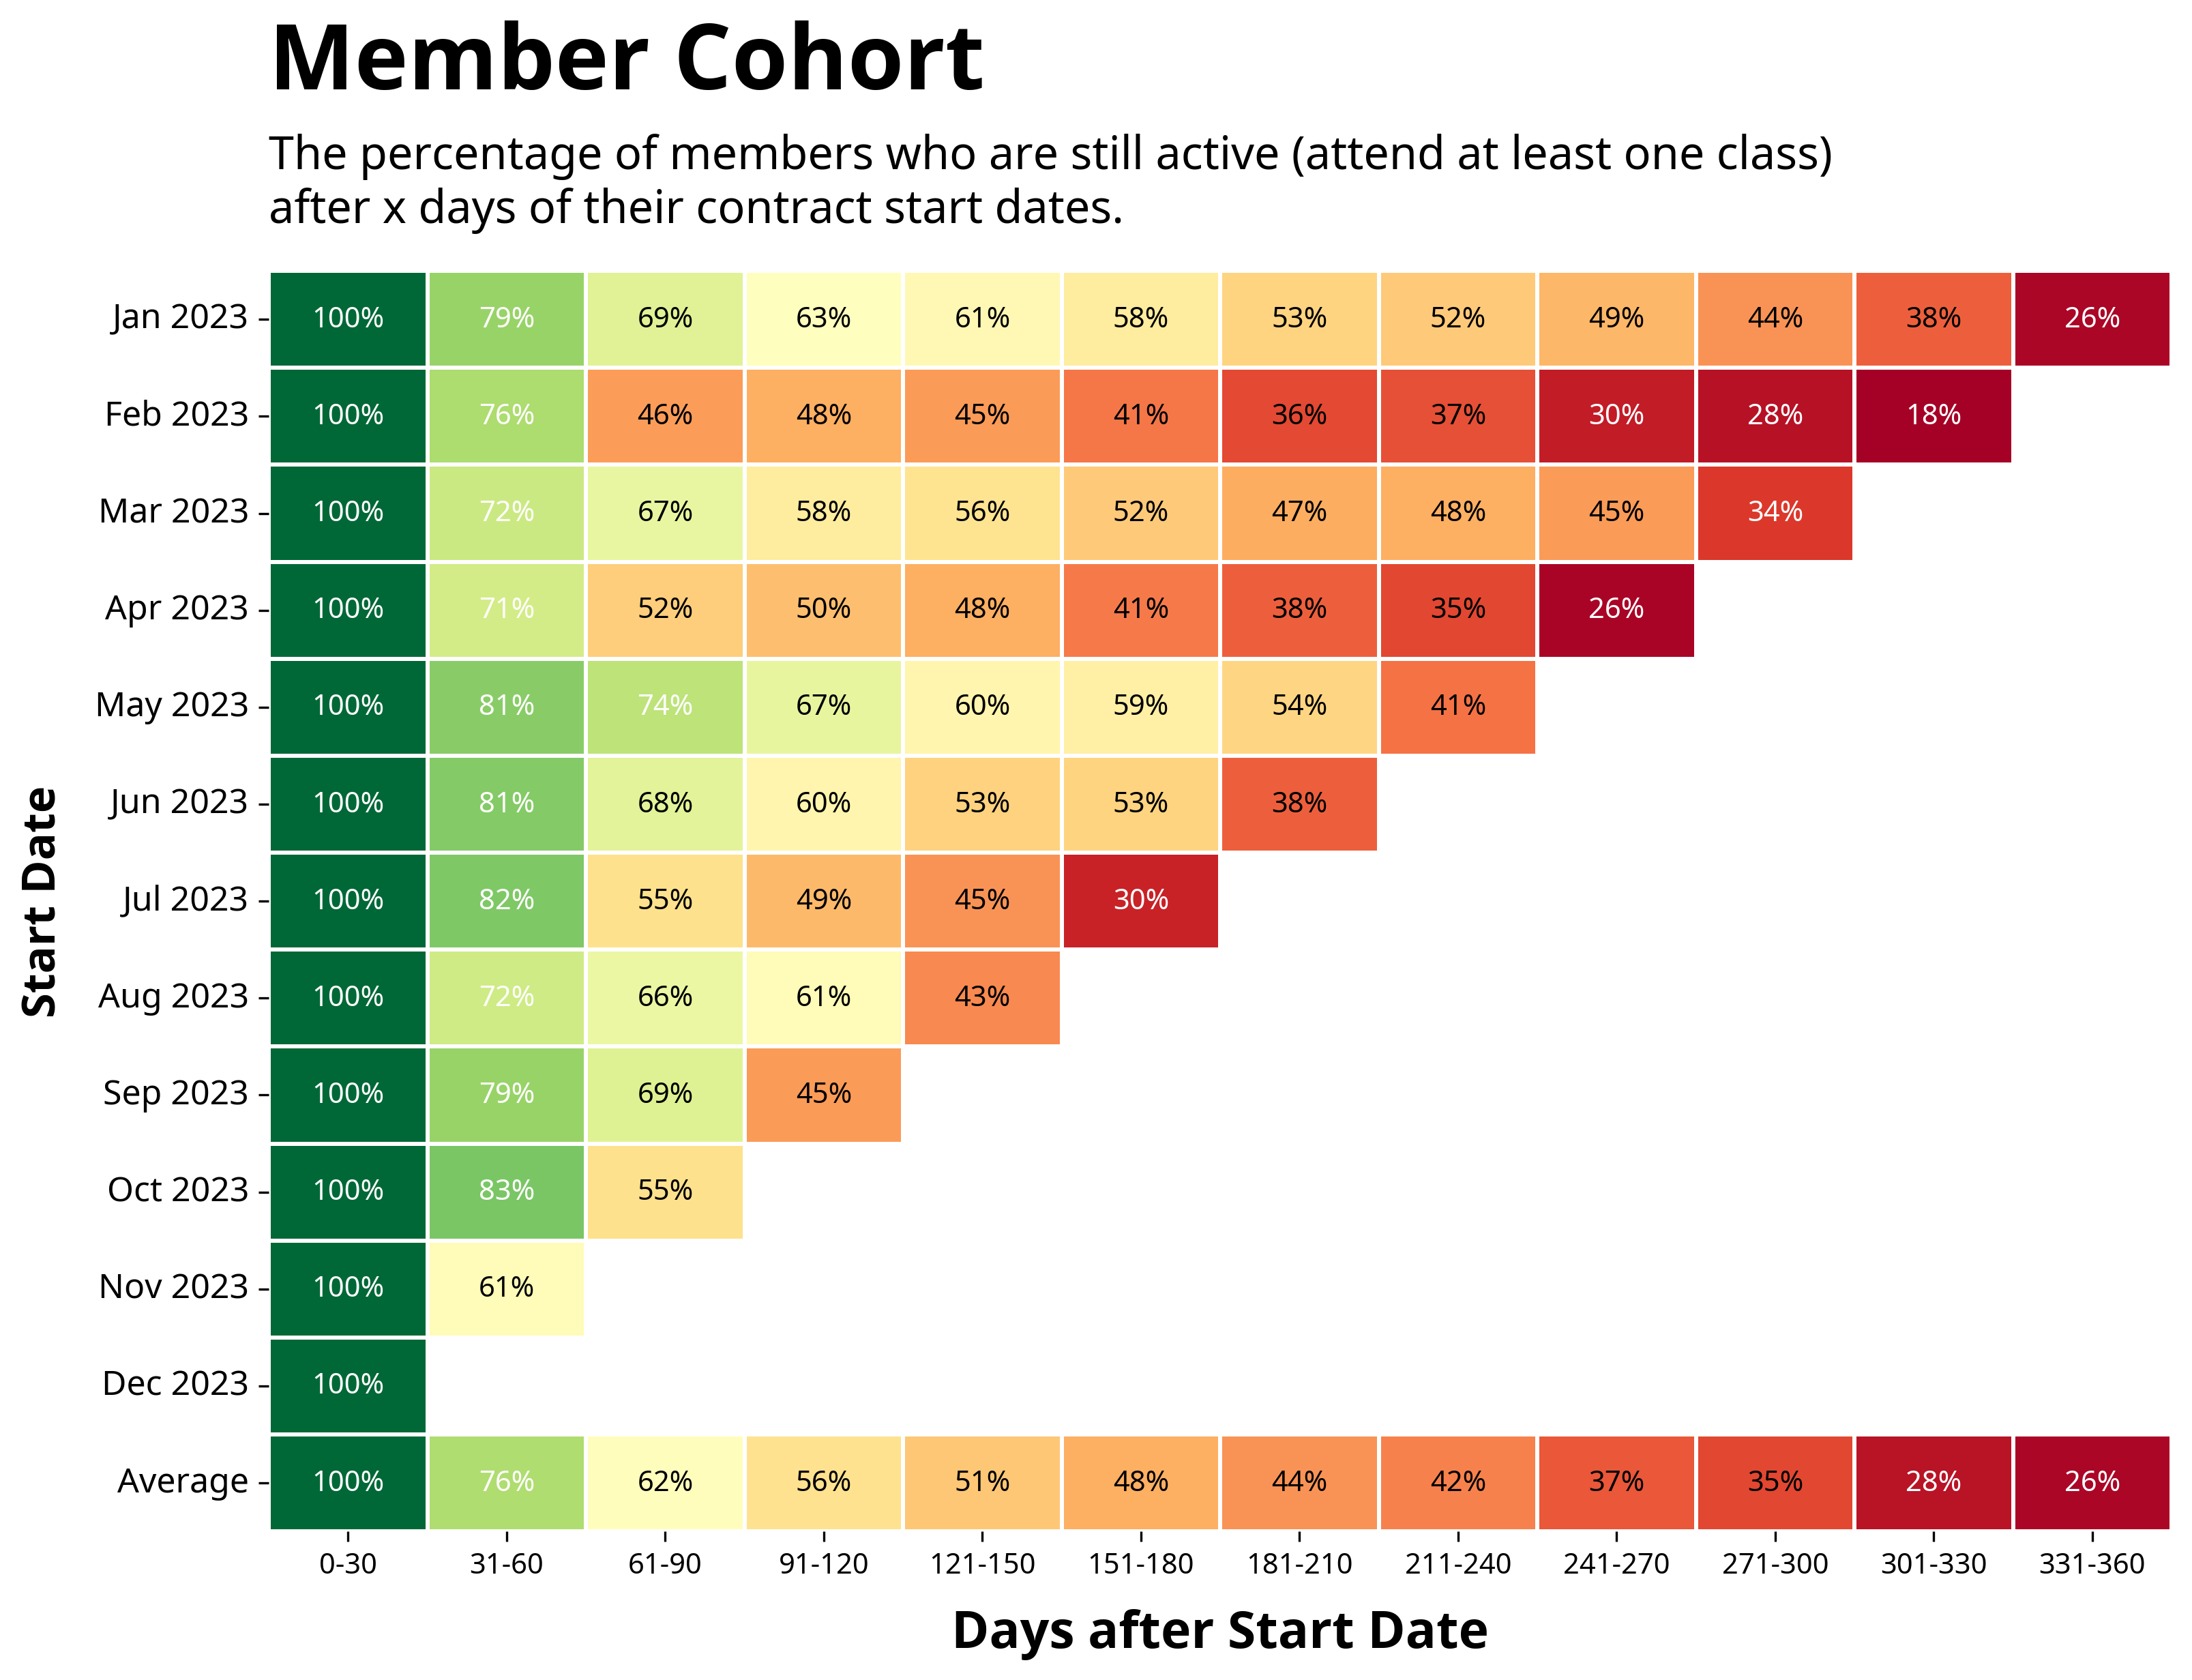

In [ ]:
df_cohort = module.make_cohort(df_cohort_raw)
module.plot_cohort(df_cohort)

# Sheet 8: Center Population

## Population based on coco

In [ ]:
center_order = pd.CategoricalDtype(config.center_order, ordered=True)

In [ ]:
df_coco_pop = (df_coco_member
    .assign(
        # create activity for the current month
        is_active = lambda df_: module.is_active(
            df_, "start_date", "end_date", f"1 {config.month[3:]}"
        ), 
        # get student center and area
        student_center = lambda df_: df_["student_center"].fillna("Not Specified").astype(center_order),
        student_area = lambda df_: df_["student_area"].fillna("Not Specified"),
    )
    # filter only active student
    .loc[lambda df_: df_["is_active"] == True]
    # group 
    .groupby(["student_area", "student_center", "student_membership"], observed=True)
    .agg(
        num_student=("student_code", "count")
    )
    # pivot
    .reset_index()
    .pivot(
        index=["student_area", "student_center"],
        columns="student_membership"
    )
    .sort_index(axis="rows", level=1)
    .fillna(0)
    .droplevel(0, axis="columns")
    .rename_axis(["Area", "Center"], axis="rows")
    .rename_axis([""], axis="columns")
)
df_coco_pop

Deluxe      GO   VIP
Area          Center                             
JKT 1         PP              263.0     0.0  36.0
              SDC              95.0     0.0   5.0
JKT 2         GC              198.0     0.0  27.0
              LW               36.0     0.0   0.0
              BSD             164.0     0.0  21.0
              TBS               2.0     0.0   1.0
JKT 3         KK              299.0     0.0  38.0
              CBB              53.0     0.0   6.0
BDG           DG              190.0     0.0  12.0
SBY           PKW              53.0     0.0   7.0
Online Center Online Center     0.0  1282.0   0.0
Corporate     Corporate        14.0    25.0   1.0

## Population based on erwin

In [ ]:
df_erwin_pop = (df_erwin_member
    # filter only active student and coco student
    .loc[
        (df_erwin_member[f"active_{config.month[3:].replace(' ', '_')}"] == True) &
        ~(df_erwin_member["core_product"].isna())
    ]
    # cast center as categorical for ordering
    .assign(
        center=lambda df_: df_["center"].astype(center_order)
    )
    .groupby(["area","center", "core_product"], observed=True)
    .agg(
        num_student=("center", "count")
    )
    # pivot
    .reset_index()
    .pivot(
        index=["area", "center"],
        columns="core_product"
    )
    .sort_index(axis="rows", level=1)
    .fillna(0)
    .droplevel(0, axis="columns")
    .rename_axis(["Area", "Center"], axis="rows")
    .rename_axis([""], axis="columns")
)
df_erwin_pop

Deluxe      Go   VIP
Area          Center                             
JKT 1         PP              218.0     0.0  38.0
              SDC             101.0     0.0  14.0
JKT 2         GC              210.0     0.0  34.0
              LW               79.0     0.0   1.0
              BSD             220.0     0.0  28.0
              TBS               0.0     0.0   1.0
JKT 3         KK              248.0     0.0  42.0
              CBB              78.0     0.0  11.0
BDG           DG              267.0     0.0  10.0
SBY           PKW              69.0     0.0   8.0
Online Center Online Center     0.0  1310.0   0.0
Corporate     Corporate         6.0    29.0   2.0
Other         HO                3.0     0.0   3.0
              NST            1026.0     0.0  73.0

# Data: Class Mapping

In [ ]:
df_class_mapping = (
    df_sess_full
    # ! exclude GOC
    .loc[df_sess_full["class_mode"] != "GOC"]
    .assign(
        class_grouping=lambda df_: df_["class_type_grouped"].map(module.class_grouping)
    )
    .groupby(["class_grouping", "class_mode", "class_type_grouped", "class_type"])
    .agg(
        total_scheduled_session=("index", "nunique"),
        # count how many rows have status "Given"
        total_delivered_session=("class_status", lambda c: (c == "Given").sum()),
    )
    .rename_axis(["Class Grouping", "Class Mode", "Class Type Grouped", "Class Type"])
    .rename(columns=lambda c: c.replace("_", " ").title())
)

# Save DF

In [ ]:
path= Path.cwd() / f'output/Experience Management Report (Source Code) - {config.month_noncoco}.xlsx'
sheets= [
    'Center Population Erwin',
    'Center Population Coco',
    'Class Session & Utilization', 
    'ET Utilization',
    'Community Class',
    'Community Class - Full',
    'Ooolab',
    'Data - Session',
    'Data - Class Mapping'
]
dfs= [
    df_erwin_member, 
    df_coco_member,  
    class_session, 
    et_util, 
    df_comm, 
    df_comm_full,
    ooolab,
    df_sess_full,
    df_class_mapping
]
 
import os
if not os.path.exists(path):
    module.save_multiple_dfs(dfs, sheets, path)
    print('File saved.')
else:
    print('File already exist.')

File already exist.


# Experiment

In [ ]:
# teachers = [
#     "Lawrence Moore John",
#     "Algar Sinclair Alexander John",
#     "Jane Quinn Madeline",
#     "Handayani Khaerunisyah Risma",
#     "Johanson Brian",
#     "Jurado Michael John",
#     "Phillips Toby",
#     "Oktavia Cindy",
#     "Fairuz Muhammad",
# ]
# for teacher in teachers:
#     result = (df_sess_full
#         .loc[df_sess_full['teacher'] == teacher, ['class_date', 'class_time', 'class_duration']]
#         .drop_duplicates()
#         .assign(class_hour= lambda df_: df_['class_time'].astype(str).str[:2])
#         .groupby('class_date')
#         .agg(
#             class_hour= ('class_hour', lambda x: ', '.join(x)),
#             total_hours= ('class_duration', 'sum')
#         )
#         .loc[lambda df_: df_['total_hours'] <= 6]
#         .reset_index()
#         .assign(
#                 class_date=lambda df_: df_["class_date"].dt.strftime("%d %b"), 
#                 total_hours=lambda df_: df_["total_hours"].astype(int)
#         )
#     )
#     print(teacher)
#     print(result.to_markdown(), end="\n\n")

Lawrence Moore John
|    | class_date   | class_hour             |   total_hours |
|---:|:-------------|:-----------------------|--------------:|
|  0 | 01 Dec       | 13, 14, 16, 17, 19, 20 |             6 |
|  1 | 04 Dec       | 12, 15, 16, 17, 19, 20 |             6 |
|  2 | 05 Dec       | 16, 18, 19, 20, 13     |             6 |
|  3 | 06 Dec       | 15, 18, 19, 20, 12, 16 |             6 |
|  4 | 11 Dec       | 13, 15, 16, 17, 19, 20 |             6 |
|  5 | 12 Dec       | 12, 15, 16, 18, 19, 20 |             6 |
|  6 | 13 Dec       | 13, 14, 17, 19, 20     |             5 |
|  7 | 14 Dec       | 13, 15, 18, 19, 20     |             5 |
|  8 | 15 Dec       | 13, 14, 16, 17, 19, 20 |             6 |
|  9 | 18 Dec       | 13, 15, 16, 17, 19, 20 |             6 |
| 10 | 20 Dec       | 12, 15, 16, 18, 19, 20 |             6 |
| 11 | 21 Dec       | 13, 16, 18, 19, 20, 15 |             6 |
| 12 | 22 Dec       | 13, 14, 15, 17, 19, 20 |             6 |
| 13 | 25 Dec       | 12, 14, 15, 1